# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [ ]:
# установим последнюю версию wandb
!pip3 install -q --upgrade wandb

In [ ]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
  random.seed(seed) # фиксируем генератор случайных чисел
  os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
  np.random.seed(seed) # фиксируем генератор случайных чисел numpy
  torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
  torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
  torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
  torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

Выпишем все классы для последующего использования. 

In [ ]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "4f44d3d5f60272e16d0b0737d50662a5eaa617b0" # вписать свой API Wandb 
  project = "Introduction to DL" # вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "sersalam" # ввести свой логин
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
             'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot') # классы датасета
  wandb = False # флаг использования Wandb


In [ ]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [ ]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(0.2859, 0.3530)])

Загружаем данные.

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data)
test_loader = torch.utils.data.DataLoader(test_data)

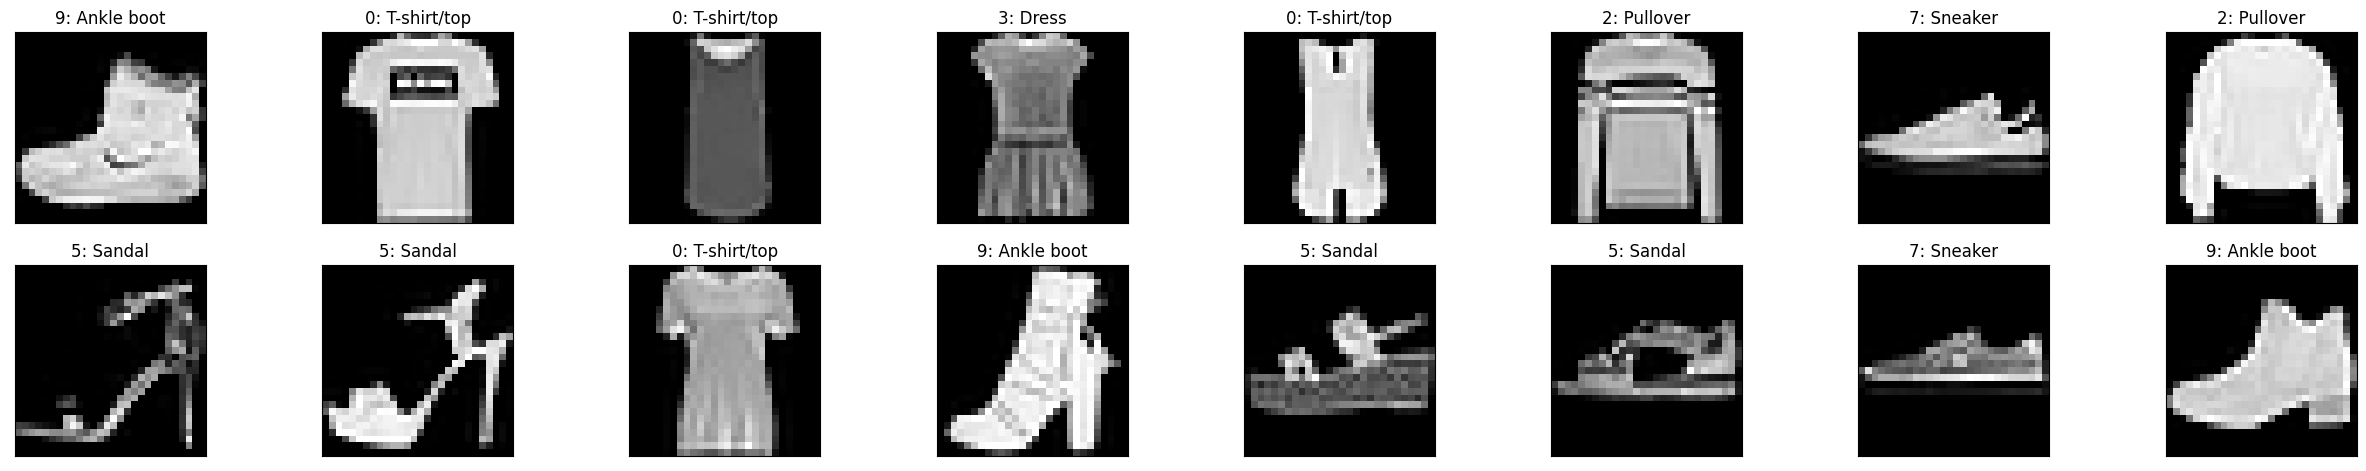

In [ ]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 5))

for idx in np.arange(16):
  plt.subplot(2,8,idx+1) # отрисуем 16 картинок
  plt.tight_layout() 
  plt.imshow(images[0][0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'{labels.numpy()[0]}: {CFG.classes[labels]}')
  
  images, labels = next(dataiter)
  images = images.numpy()

Создаем полносвязаннную нейронную сеть. 

In [ ]:
class My_Net(nn.Module): # наследуемся от класса nn.Module
  def __init__(self, constant_weight=None, normal=False, 
               xavier_uniform=False, he_normal=False):
    super(My_Net, self).__init__()
    
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 10)
        
    # инициализируем по-разному веса
    if (constant_weight is not None):
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.constant_(m.weight, constant_weight)
          nn.init.constant_(m.bias, 0)
    
    if normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.normal_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if xavier_uniform:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.xavier_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if he_normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
    
            
  def forward(self, x):
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = My_Net()
model = model.to(device) # переводим модель на GPU

print(model) # посмотрим на нашу модель

My_Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

In [ ]:
# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0
    
    n_ex = len(train_loader)
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        
        # обнуляем градиенты!
        optimizer.zero_grad()

        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        
        # обратный проход
        train_loss.backward()
        
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))
    
    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [ ]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводим модель в режим инференса
    test_loss = 0
    correct = 0

    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    
    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [ ]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))
  
    use_cuda = torch.cuda.is_available() # проверяем доступность GPU 

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device('cuda' if use_cuda else 'cpu') # выделили устройство
    
    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

zsh:1: command not found: nvidia-smi


Запускаем обучение. Цель - получить на тесте значение accuracy не менее 98%.

In [ ]:
main(model)


Epoch: 1


100%|██████████| 60000/60000 [01:33<00:00, 642.76it/s]



Train set: Average loss: 0.0002, Accuracy: 82%
Test set: Average loss: 0.0000, Accuracy: 83%

Epoch: 2


100%|██████████| 60000/60000 [01:32<00:00, 645.56it/s]



Train set: Average loss: 0.0001, Accuracy: 86%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 3


100%|██████████| 60000/60000 [01:31<00:00, 654.39it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 4


100%|██████████| 60000/60000 [01:32<00:00, 648.92it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 5


100%|██████████| 60000/60000 [01:33<00:00, 640.11it/s]



Train set: Average loss: 0.0000, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 6


100%|██████████| 60000/60000 [01:33<00:00, 642.25it/s]



Train set: Average loss: 0.0000, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 7


100%|██████████| 60000/60000 [01:32<00:00, 647.30it/s]



Train set: Average loss: 0.0000, Accuracy: 90%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 8


100%|██████████| 60000/60000 [01:33<00:00, 645.11it/s]



Train set: Average loss: 0.0000, Accuracy: 90%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 9


100%|██████████| 60000/60000 [01:32<00:00, 652.13it/s]



Train set: Average loss: 0.0000, Accuracy: 90%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 10


100%|██████████| 60000/60000 [01:33<00:00, 643.80it/s]



Train set: Average loss: 0.0000, Accuracy: 90%
Test set: Average loss: 0.0000, Accuracy: 87%
Training is end!


Пробуем другие оптимизаторы.

In [ ]:
# Адам плохо себя показывает при lr=0.01

optimizer = optim.Adam(params=model.parameters(), lr=3e-4)

In [ ]:
main(model)


Epoch: 1


100%|██████████| 60000/60000 [02:09<00:00, 464.09it/s]



Train set: Average loss: 0.0000, Accuracy: 83%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 2


100%|██████████| 60000/60000 [02:08<00:00, 466.87it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 3


100%|██████████| 60000/60000 [02:09<00:00, 464.82it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 4


100%|██████████| 60000/60000 [02:12<00:00, 453.20it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 5


100%|██████████| 60000/60000 [02:09<00:00, 462.70it/s]



Train set: Average loss: 0.0000, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 6


100%|██████████| 60000/60000 [02:10<00:00, 459.27it/s]



Train set: Average loss: 0.0000, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 7


100%|██████████| 60000/60000 [02:09<00:00, 462.03it/s]



Train set: Average loss: 0.0000, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 8


 73%|███████▎  | 43688/60000 [01:33<00:32, 498.26it/s]

In [ ]:
# RMSProp плохо себя показывает при lr=0.01

optimizer = optim.RMSprop(params=model.parameters(), lr=3e-4)

In [ ]:
main(model)


Epoch: 1


100%|████████████████████████████████████| 60000/60000 [02:56<00:00, 340.06it/s]



Train set: Average loss: 0.0000, Accuracy: 83%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 2


100%|████████████████████████████████████| 60000/60000 [03:10<00:00, 315.14it/s]



Train set: Average loss: 0.0000, Accuracy: 85%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 3


100%|████████████████████████████████████| 60000/60000 [03:14<00:00, 308.86it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 4


100%|████████████████████████████████████| 60000/60000 [03:16<00:00, 305.54it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 5


100%|████████████████████████████████████| 60000/60000 [03:17<00:00, 303.15it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 6


100%|████████████████████████████████████| 60000/60000 [03:15<00:00, 306.62it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 7


100%|████████████████████████████████████| 60000/60000 [03:16<00:00, 304.82it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 8


100%|████████████████████████████████████| 60000/60000 [03:57<00:00, 252.73it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 9


100%|████████████████████████████████████| 60000/60000 [04:14<00:00, 235.82it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 10


100%|████████████████████████████████████| 60000/60000 [04:10<00:00, 239.53it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 86%
Training is end!


<b> RMSProp на тесте дал чуть хуже результат, а Adam и SGD дали плюс-минус один результат, за исключением что Adam сошёлся быстрей. Далее будем пользоваться им, хоть это и не гарантирует что дальше он также будет лучшим.

Может стоить добавить еще пару слоев? Как уже говорилось ранее, deep learning - это пространство для экспериментов и творчества. Дерзайте!

<b> Создадим новую сеть с большим кол-вом слоёв

In [ ]:
class SkyNet(nn.Module): # наследуемся от класса nn.Module
  def __init__(self, constant_weight=None, normal=False, 
               xavier_uniform=False, he_normal=False):
    super(SkyNet, self).__init__()
    
    self.fc1 = nn.Linear(784, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 32)
    self.fc6 = nn.Linear(32, 10)
        
    # инициализируем по-разному веса
    if (constant_weight is not None):
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.constant_(m.weight, constant_weight)
          nn.init.constant_(m.bias, 0)
    
    if normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.normal_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if xavier_uniform:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.xavier_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if he_normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
    
            
  def forward(self, x):
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = self.fc6(x)
    return x

In [ ]:
new_model = SkyNet()
new_model = new_model.to(device)

optimizer = optim.Adam(params=new_model.parameters(), lr=3e-4)

In [ ]:
main(new_model)


Epoch: 1


100%|████████████████████████████████████| 60000/60000 [08:00<00:00, 124.76it/s]



Train set: Average loss: 0.0000, Accuracy: 81%
Test set: Average loss: 0.0000, Accuracy: 83%

Epoch: 2


100%|████████████████████████████████████| 60000/60000 [08:53<00:00, 112.43it/s]



Train set: Average loss: 0.0000, Accuracy: 86%
Test set: Average loss: 0.0000, Accuracy: 84%

Epoch: 3


100%|████████████████████████████████████| 60000/60000 [09:53<00:00, 101.02it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 4


100%|█████████████████████████████████████| 60000/60000 [10:30<00:00, 95.16it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 5


100%|█████████████████████████████████████| 60000/60000 [11:11<00:00, 89.29it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 6


100%|█████████████████████████████████████| 60000/60000 [10:37<00:00, 94.10it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 7


100%|█████████████████████████████████████| 60000/60000 [11:26<00:00, 87.34it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 8


100%|█████████████████████████████████████| 60000/60000 [13:49<00:00, 72.37it/s]



Train set: Average loss: 0.0000, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 9


100%|█████████████████████████████████████| 60000/60000 [11:10<00:00, 89.51it/s]



Train set: Average loss: 0.0000, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 10


100%|█████████████████████████████████████| 60000/60000 [11:16<00:00, 88.75it/s]



Train set: Average loss: 0.0000, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 87%
Training is end!


<b> Добавление дополнительных слоёв не сильно чем-то помогло. Проверим одну гипотезу - попробуем в первых слоях сокращать признаковое пространство быстрее чем в последних слоях. Например в первом слое сократим в 4-5 раза, в последних слоях в 2-3.

In [ ]:
class SkyNet(nn.Module): # наследуемся от класса nn.Module
  def __init__(self, constant_weight=None, normal=False, 
               xavier_uniform=False, he_normal=False):
    super(SkyNet, self).__init__()
    
    self.fc1 = nn.Linear(784, 196)
    self.fc2 = nn.Linear(196, 66)
    self.fc3 = nn.Linear(66, 33)
    self.fc4 = nn.Linear(33, 21)
    self.fc5 = nn.Linear(21, 14)
    self.fc6 = nn.Linear(14, 10)
        
    # инициализируем по-разному веса
    if (constant_weight is not None):
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.constant_(m.weight, constant_weight)
          nn.init.constant_(m.bias, 0)
    
    if normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.normal_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if xavier_uniform:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.xavier_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if he_normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
    
            
  def forward(self, x):
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = self.fc6(x)
    return x

In [ ]:
new_model = SkyNet()
new_model = new_model.to(device)

optimizer = optim.Adam(params=new_model.parameters(), lr=3e-4)

In [ ]:
main(new_model)


Epoch: 1


100%|████████████████████████████████████| 60000/60000 [03:16<00:00, 304.81it/s]



Train set: Average loss: 0.0000, Accuracy: 81%
Test set: Average loss: 0.0000, Accuracy: 84%

Epoch: 2


100%|████████████████████████████████████| 60000/60000 [03:42<00:00, 269.91it/s]



Train set: Average loss: 0.0000, Accuracy: 86%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 3


100%|████████████████████████████████████| 60000/60000 [03:52<00:00, 258.45it/s]



Train set: Average loss: 0.0000, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 4


  9%|███▍                                 | 5569/60000 [00:18<03:03, 295.86it/s]


KeyboardInterrupt: 

<b> Прервём задачу. Accuracy на тесте стал на 1% больше чем в предыдущем эксперименте, но сильного результа нам это не дало. Попробуем уменьшать кол-во слоёв

In [ ]:
class SkyNet(nn.Module): # наследуемся от класса nn.Module
  def __init__(self, constant_weight=None, normal=False, 
               xavier_uniform=False, he_normal=False):
    super(SkyNet, self).__init__()
    
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 16)
        
    # инициализируем по-разному веса
    if (constant_weight is not None):
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.constant_(m.weight, constant_weight)
          nn.init.constant_(m.bias, 0)
    
    if normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.normal_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if xavier_uniform:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.xavier_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if he_normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
    
            
  def forward(self, x):
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [ ]:
new_model = SkyNet()
new_model = new_model.to(device)

optimizer = optim.Adam(params=new_model.parameters(), lr=3e-4)

In [ ]:
main(new_model)


Epoch: 1


100%|████████████████████████████████████| 60000/60000 [04:59<00:00, 200.56it/s]



Train set: Average loss: 0.0000, Accuracy: 82%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 2


100%|████████████████████████████████████| 60000/60000 [04:26<00:00, 225.18it/s]



Train set: Average loss: 0.0000, Accuracy: 86%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 3


100%|████████████████████████████████████| 60000/60000 [04:34<00:00, 218.86it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 4


100%|████████████████████████████████████| 60000/60000 [04:42<00:00, 212.73it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 5


  2%|▊                                    | 1328/60000 [00:06<04:49, 202.85it/s]


KeyboardInterrupt: 

<b> Попробуем ещё по-другому

In [ ]:
class SkyNet(nn.Module): # наследуемся от класса nn.Module
  def __init__(self, constant_weight=None, normal=False, 
               xavier_uniform=False, he_normal=False):
    super(SkyNet, self).__init__()
    
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 16)
    self.fc4 = nn.Linear(16, 10)
        
    # инициализируем по-разному веса
    if (constant_weight is not None):
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.constant_(m.weight, constant_weight)
          nn.init.constant_(m.bias, 0)
    
    if normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.normal_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if xavier_uniform:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.xavier_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
        
    if he_normal:
      for m in self.modules():
        if isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight)
          nn.init.constant_(m.bias, 0)
    
            
  def forward(self, x):
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
new_model = SkyNet()
new_model = new_model.to(device)

optimizer = optim.Adam(params=new_model.parameters(), lr=3e-4)

In [ ]:
main(new_model)


Epoch: 1


100%|████████████████████████████████████| 60000/60000 [02:50<00:00, 350.90it/s]



Train set: Average loss: 0.0009, Accuracy: 82%
Test set: Average loss: 0.0000, Accuracy: 84%

Epoch: 2


100%|████████████████████████████████████| 60000/60000 [03:17<00:00, 304.29it/s]



Train set: Average loss: 0.0002, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 3


100%|████████████████████████████████████| 60000/60000 [03:12<00:00, 311.14it/s]



Train set: Average loss: 0.0000, Accuracy: 88%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 4


100%|████████████████████████████████████| 60000/60000 [03:02<00:00, 329.20it/s]



Train set: Average loss: 0.0003, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 86%

Epoch: 5


  2%|▌                                     | 974/60000 [00:03<03:02, 323.98it/s]


KeyboardInterrupt: 

<b> В общем, достичь результата на тренировке выше 87-88% уже затруднительно. Перейдём к свёрточной сети

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 6, 5) 
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(6, 12, 5)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(12*4*4, 120)
        self.act3 = torch.nn.Tanh()
        
        self.fc2 = torch.nn.Linear(120, 60)
        self.act4 = torch.nn.Tanh()
        
        self.fc3 = torch.nn.Linear(60, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [ ]:
new_model = CNN()
new_model = new_model.to(device)

optimizer = optim.Adam(params=new_model.parameters(), lr=3e-4)

In [ ]:
main(new_model)


Epoch: 1


100%|████████████████████████████████████| 60000/60000 [03:20<00:00, 299.79it/s]



Train set: Average loss: 0.0026, Accuracy: 82%
Test set: Average loss: 0.0000, Accuracy: 85%

Epoch: 2


100%|████████████████████████████████████| 60000/60000 [04:23<00:00, 227.47it/s]



Train set: Average loss: 0.0012, Accuracy: 87%
Test set: Average loss: 0.0000, Accuracy: 87%

Epoch: 3


100%|████████████████████████████████████| 60000/60000 [04:22<00:00, 228.21it/s]



Train set: Average loss: 0.0003, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 88%

Epoch: 4


100%|████████████████████████████████████| 60000/60000 [03:37<00:00, 276.45it/s]



Train set: Average loss: 0.0003, Accuracy: 89%
Test set: Average loss: 0.0000, Accuracy: 88%

Epoch: 5


100%|████████████████████████████████████| 60000/60000 [03:54<00:00, 255.80it/s]



Train set: Average loss: 0.0004, Accuracy: 90%
Test set: Average loss: 0.0000, Accuracy: 88%

Epoch: 6


  2%|▋                                     | 997/60000 [00:03<03:30, 279.89it/s]


KeyboardInterrupt: 

<b> Чуть лучше, но порог в 90% не удалось пройти :(